# Lab 5
Lucas Street, 1874989

In [203]:
%%capture
import sys
!{sys.executable} -m pip install --upgrade --user scipy numpy matplotlib pandas pyuvdata
# Also install https://github.com/HERA-Team/hera_cal

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
from hera_cal.io import HERAData

The Hydrogen Epoch of Reionization Array (HERA) is an array of radio telescopes located in [South Africa](https://goo.gl/maps/44ntQEovA51L792m6). It is currently composed of 52 dishes, each 14 meters wide, packed in a hexagonal grid.

In [521]:
filename = 'zen.2458108.57290.HH.uvh5'
hd = HERAData(filename)
selected_times = hd.times[0:6]
frequency_channels = np.arange(100, 850)
hd.read(times=selected_times, freq_chans=frequency_channels)
print('antenna numbers:', sorted(hd.antenna_numbers))
print('antenna pairs:', len(hd.get_antpairs()))

antenna numbers: [0, 1, 2, 11, 12, 13, 14, 23, 24, 25, 26, 27, 36, 37, 38, 39, 40, 41, 50, 51, 52, 53, 54, 55, 65, 66, 67, 68, 69, 70, 71, 82, 83, 84, 85, 86, 87, 88, 98, 120, 121, 122, 123, 124, 136, 137, 138, 139, 140, 141, 142, 143]
antenna pairs: 1378


In [526]:
def get_spectrogram(hd, *args, **kwargs):
    data = hd.get_data(*args, **kwargs)
    times = hd.get_times(*args, **kwargs)
    times -= times[0]
    freqs_mhz = hd.freq_array.flatten() / 1e6
    return pd.DataFrame(data, times, freqs_mhz), times, freqs_mhz

def plot_spectrogram(freqs, times, data, colorbar=True):
    # Handle case where we only have one unique time
    single_time = False
    if times[0] == times[-1]:
        single_time = True
        times = [0, 1]
    
    plt.imshow(np.abs(data), origin='bottom', extent=(freqs[0], freqs[-1], times[0], times[-1]), aspect='auto')
    
    if single_time:
        # No need for a time axis if we only have one time
        plt.gca().get_yaxis().set_visible(False)
    
    plt.ylabel('Time')
    plt.xlabel('Frequency (MHz)')
    if colorbar:
        cbar = plt.colorbar()
        cbar.set_label('Amplitude')
    
def plot_total_amplitudes(freqs, times, data):
    total_amplitudes = np.sum(np.abs(data), axis=0)
    plt.plot(freqs, total_amplitudes)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Amplitude')
    plt.xlim(freqs[0], freqs[-1])

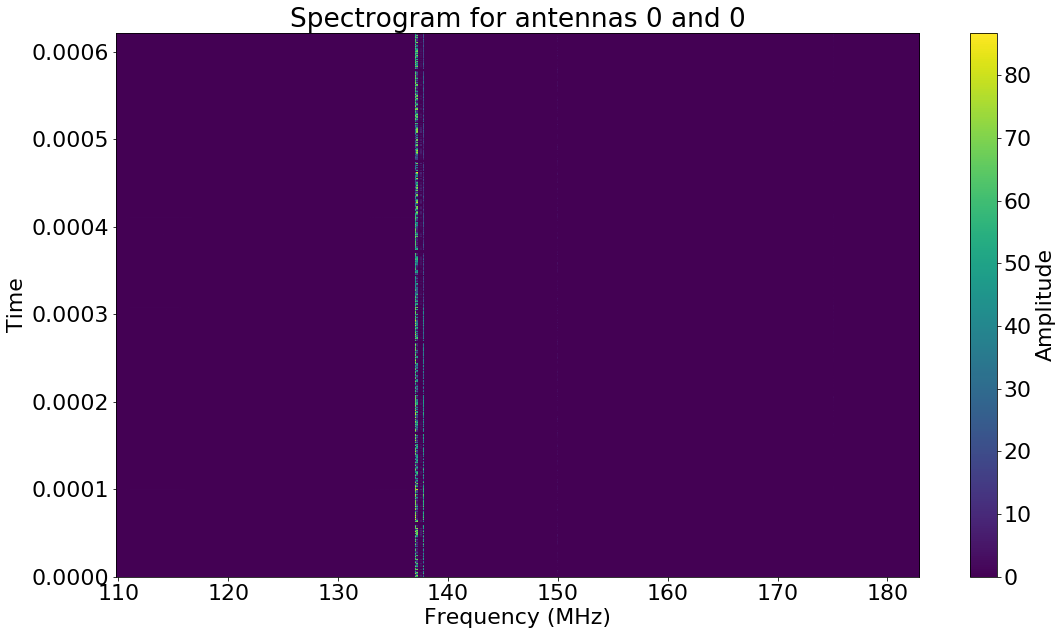

In [527]:
no_dupe_pairs = [(a, b) for a, b in hd.get_antpairs() if a != b]
hd.select(bls=no_dupe_pairs)

data, times, freqs_mhz = get_spectrogram(hd, 'XX')
plt.title('Spectrogram for antennas 0 and 0')
plot_spectrogram(freqs_mhz, times, data, colorbar=True)

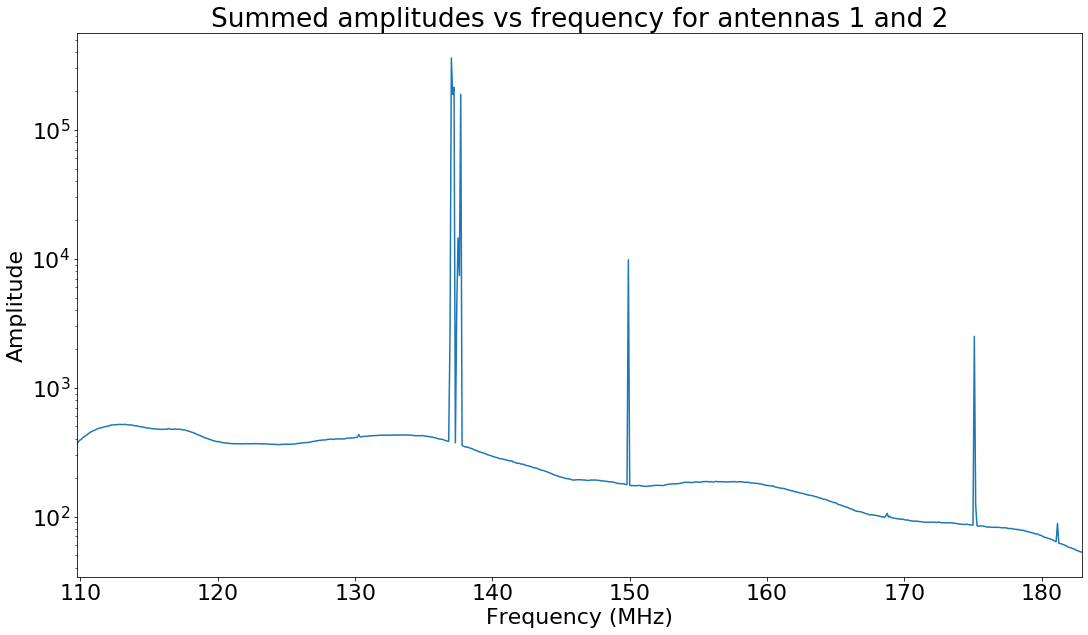

In [528]:
plot_total_amplitudes(freqs_mhz, times, data)
plt.title('Summed amplitudes vs frequency for antennas 1 and 2')
plt.yscale('log')

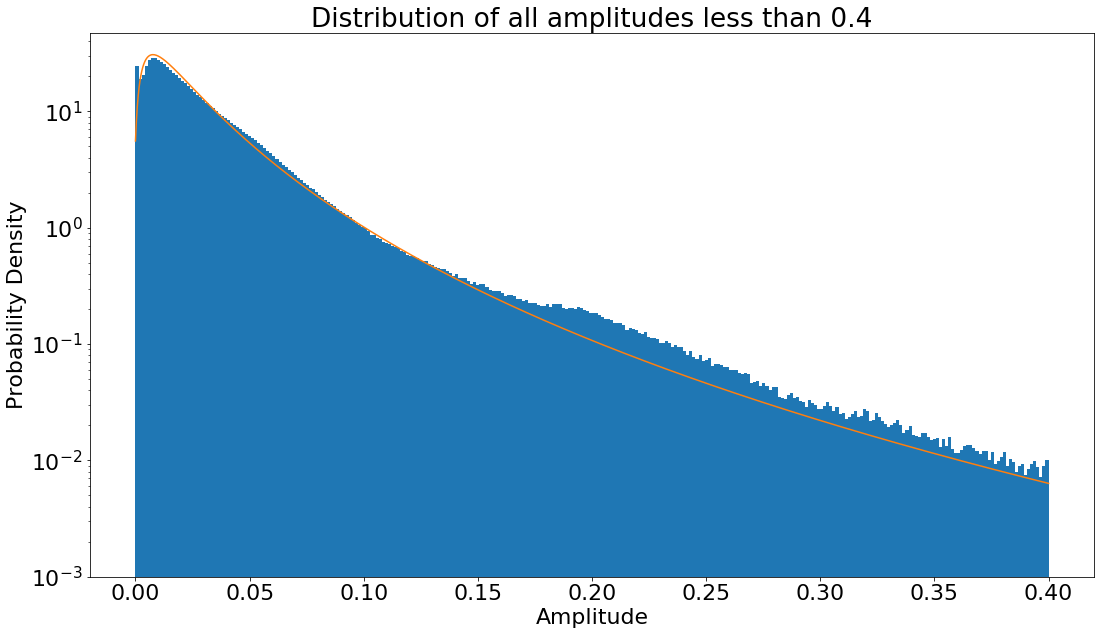

In [529]:
all_antenna_data, _, _ = get_spectrogram(hd, 'XX')
hist_data = np.abs(np.array(all_antenna_data).flatten())
max_amplitude = 0.4
hist_data = hist_data[(hist_data > -max_amplitude) & (hist_data < max_amplitude)]
# print(len(hist_data))
plt.title(f"Distribution of all amplitudes less than {max_amplitude}")
plt.xlabel('Amplitude')
plt.ylabel('Probability Density')
plt.hist(hist_data, bins=300, density=True);
# plt.yscale('log')

s, loc, scale = stats.lognorm.fit(hist_data[0:500_000])
dist = stats.lognorm(s, loc, scale)
x = np.linspace(0, 0.4, 1000)
y = dist.pdf(x)
plt.plot(x, y)
plt.yscale('log')
plt.ylim(1e-3);